# Introducción

En este notebook realizaremos un análisis exploratorio y estadístico de dos variables oceánicas clave en la zona costera occidental del Golfo de California:

1. **Temperatura Superficial del Mar (TSM)**  
   – Periodo de estudio: **enero 1981 – diciembre 2018**  
   – Objetivo: caracterizar su variabilidad interanual, intranual y estacional, y encontrar sus frecuencias dominantes de oscilación.

2. **Concentración de Clorofila a (Chl a)**  
   – Periodo de estudio: **enero 1997 – diciembre 2018**  
   – Objetivo: cuantificar su variabilidad temporal y determinar sus ciclos de variación principales.

Además, profundizaremos en:

- **Regionalización** de la costa noroeste de México, agrupando subregiones con comportamientos climatológicos similares, mediante técnicas de reducción de dimensionalidad y clustering multivariante.
- **Efecto del ENSO** (El Niño–Oscilación del Sur):  
  - Cartografía de fases ENSO (Niño, Neutro, Niña) sobre los datos.  
  - Comparación de medias y varianzas de TSM y Chl a en cada fase.  
  - Análisis estacional dentro de cada fase para detectar respuesta diferencial en ciclos anuales.

**Metodología general**:  
1. **Carga y limpieza** de datos temporales.  
2. **Cómputo de estadísticos descriptivos** (media, desviación estándar, percentiles).  
3. **Análisis de frecuencias** vía periodograma para identificar ciclos dominantes (p.ej. anual, semestral).  
4. **Regionalización** usando PCA + k-means (o DBSCAN) aplicado a indicadores multivariados TSM–Chl a.  
5. **Análisis ENSO**: unión con índice ONI, segmentación por fase, pruebas estadísticas (ANOVA/Kruskal–Wallis), y visualizaciones comparativas (boxplots, series descompuestas).

A continuación implementaremos paso a paso estas etapas en Python, apoyándonos en librerías como `pandas`, `numpy`, `scipy`, `scikit-learn` y `statsmodels`. 

In [6]:
# Manipulación y análisis de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Análisis de series de tiempo
from scipy.signal import periodogram
from pathlib import Path

In [7]:
ruta_actual = Path.cwd()
PROJECT_DIR = ruta_actual.parents[1]
PROCESSED_DIR     = PROJECT_DIR / 'data' / 'processed'

In [8]:
df = pd.read_csv(PROCESSED_DIR / 'data.csv')

In [9]:
df.head()

,fecha,estacion,tsm,ano,mes,chla,mes_num,est_index,longitud,latitud,evento,oni,estacion_climatica
0,1981-09-01,est_1,30.5000,NaN,9,NaN,NaN,0.0,-109.3,23.8,Neutro,-0.2,SON
1,1981-09-01,est_10,28.6250,NaN,9,NaN,NaN,9.0,-112.3,27.6,Neutro,-0.2,SON
2,1981-09-01,est_11,29.1583,NaN,9,NaN,NaN,10.0,-112.6,28.0,Neutro,-0.2,SON
3,1981-09-01,est_12,28.8750,NaN,9,NaN,NaN,11.0,-112.9,28.5,Neutro,-0.2,SON
4,1981-09-01,est_13,26.9667,NaN,9,NaN,NaN,12.0,-113.2,28.9,Neutro,-0.2,SON


In [10]:
# 1. Inspección básica
print(df.shape)        # filas × columnas
print(df.dtypes)       # confirma que 'fecha' es datetime y revisa tipos de otras columnas
print(df.head(5))      # primeras 5 filas para ver la estructura de datos
print(df.isna().sum()) # cuántos valores faltan en cada columna

(7582, 13)
fecha                  object
estacion               object
tsm                   float64
ano                   float64
mes                     int64
chla                  float64
mes_num               float64
est_index             float64
longitud              float64
latitud               float64
evento                 object
oni                   float64
estacion_climatica     object
dtype: object
        fecha estacion      tsm  ano  mes  chla  mes_num  est_index  longitud  \
0  1981-09-01    est_1  30.5000  NaN    9   NaN      NaN        0.0    -109.3   
1  1981-09-01   est_10  28.6250  NaN    9   NaN      NaN        9.0    -112.3   
2  1981-09-01   est_11  29.1583  NaN    9   NaN      NaN       10.0    -112.6   
3  1981-09-01   est_12  28.8750  NaN    9   NaN      NaN       11.0    -112.9   
4  1981-09-01   est_13  26.9667  NaN    9   NaN      NaN       12.0    -113.2   

   latitud  evento  oni estacion_climatica  
0     23.8  Neutro -0.2                SON  
1     27

In [11]:
# Convertir la columna fecha en datatime
df["fecha"] = pd.to_datetime(df["fecha"])

In [12]:
print(df.dtypes)  

fecha                 datetime64[ns]
estacion                      object
tsm                          float64
ano                          float64
mes                            int64
chla                         float64
mes_num                      float64
est_index                    float64
longitud                     float64
latitud                      float64
evento                        object
oni                          float64
estacion_climatica            object
dtype: object


In [13]:
tsm = df[(df['fecha'].dt.year >= 1981) & (df['fecha'].dt.year <= 2018)]
chla = df[(df['fecha'].dt.year >= 1997) & (df['fecha'].dt.year <= 2018)].dropna()

In [14]:
tsm

,fecha,estacion,tsm,ano,mes,chla,mes_num,est_index,longitud,latitud,evento,oni,estacion_climatica
0,1981-09-01,est_1,30.5000,NaN,9,NaN,NaN,0.0,-109.3,23.8,Neutro,-0.2,SON
1,1981-09-01,est_10,28.6250,NaN,9,NaN,NaN,9.0,-112.3,27.6,Neutro,-0.2,SON
2,1981-09-01,est_11,29.1583,NaN,9,NaN,NaN,10.0,-112.6,28.0,Neutro,-0.2,SON
3,1981-09-01,est_12,28.8750,NaN,9,NaN,NaN,11.0,-112.9,28.5,Neutro,-0.2,SON
4,1981-09-01,est_13,26.9667,NaN,9,NaN,NaN,12.0,-113.2,28.9,Neutro,-0.2,SON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7577,2018-10-01,est_5,29.0756,2018.0,10,0.2772,10.0,4.0,-110.8,25.3,Niño,0.8,SON
7578,2018-10-01,est_6,28.6689,2018.0,10,0.3656,10.0,5.0,-111.1,25.8,Niño,0.8,SON
7579,2018-10-01,est_7,28.7222,2018.0,10,0.5083,10.0,6.0,-111.2,26.3,Niño,0.8,SON
7580,2018-10-01,est_8,28.4456,2018.0,10,0.5119,10.0,7.0,-111.5,26.8,Niño,0.8,SON


In [15]:
print("TSM (1981–2018):")
print(tsm['tsm'].describe(), "\n")

TSM (1981–2018):
count    7582.000000
mean       24.281074
std         4.764086
min        10.368800
25%        20.175000
50%        24.325000
75%        28.734575
max        39.300000
Name: tsm, dtype: float64 



In [16]:
print("Clorofila a (1997–2018):")
print(chla['chla'].describe(), "\n")

Clorofila a (1997–2018):
count    4318.000000
mean        1.213277
std         1.012386
min         0.109800
25%         0.496325
50%         0.968050
75%         1.616625
max         9.067800
Name: chla, dtype: float64 



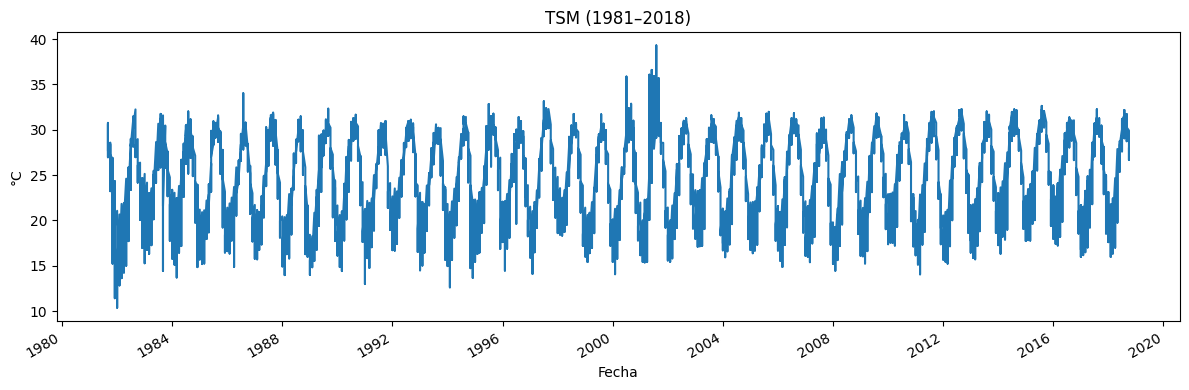

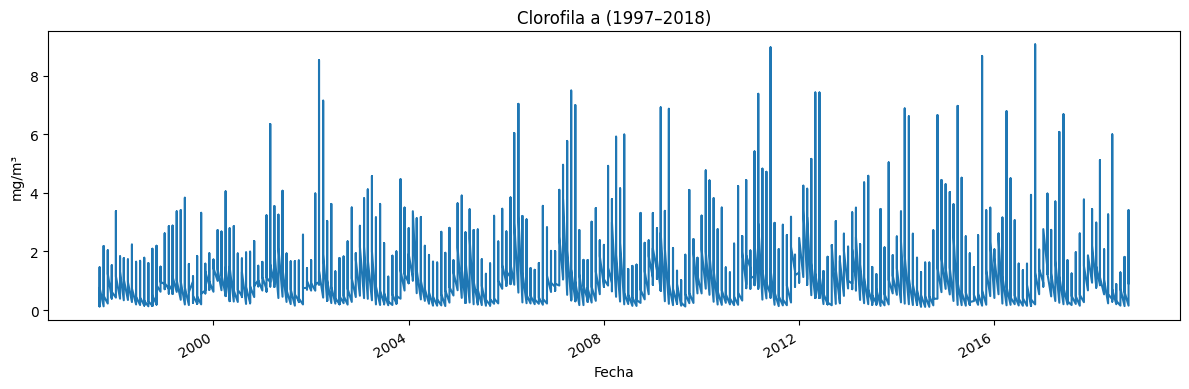

In [17]:
plt.figure(figsize=(12,4))
plt.plot(tsm['fecha'], tsm['tsm'])
plt.title('TSM (1981–2018)')
plt.xlabel('Fecha')
plt.ylabel('°C')
plt.gcf().autofmt_xdate()   # formatea fechas en el eje x
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(chla['fecha'], chla['chla'])
plt.title('Clorofila a (1997–2018)')
plt.xlabel('Fecha')
plt.ylabel('mg/m³')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

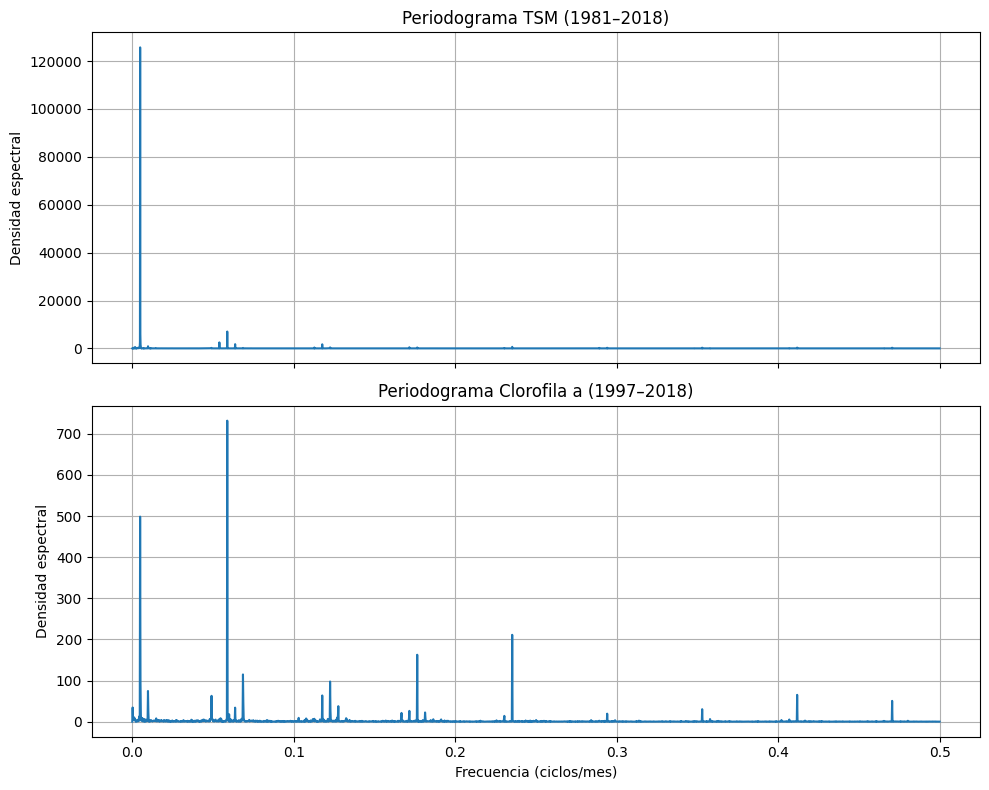

In [18]:
f_tsm, Pxx_tsm   = periodogram(tsm['tsm'], fs=1, detrend='linear')
f_chla, Pxx_chla = periodogram(chla['chla'], fs=1, detrend='linear')

# 5. Graficar periodogramas
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax1.plot(f_tsm, Pxx_tsm)
ax1.set_title('Periodograma TSM (1981–2018)')
ax1.set_ylabel('Densidad espectral')
ax1.grid(True)

ax2.plot(f_chla, Pxx_chla)
ax2.set_title('Periodograma Clorofila a (1997–2018)')
ax2.set_xlabel('Frecuencia (ciclos/mes)')
ax2.set_ylabel('Densidad espectral')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [19]:
def top_peaks(freq, psd, n=3):
    idx = np.argsort(psd)[-n:][::-1]
    return list(zip(freq[idx], psd[idx]))

print("Frecuencias dominantes TSM (ciclos/mes, potencia):")
print(top_peaks(f_tsm, Pxx_tsm, n=5))
print("\nFrecuencias dominantes Clorofila a (ciclos/mes, potencia):")
print(top_peaks(f_chla, Pxx_chla, n=5))

Frecuencias dominantes TSM (ciclos/mes, potencia):
[(np.float64(0.0048799788973885525), np.float64(125732.98209727819)), (np.float64(0.05882352941176471), np.float64(7029.937399286494)), (np.float64(0.005011870218939594), np.float64(5839.854213327759)), (np.float64(0.00474808757583751), np.float64(2588.4803915366642)), (np.float64(0.05394355051437616), np.float64(2494.5226157637703))]

Frecuencias dominantes Clorofila a (ciclos/mes, potencia):
[(np.float64(0.058823529411764705), np.float64(732.0658318931544)), (np.float64(0.004863362667901806), np.float64(498.689169736915)), (np.float64(0.23529411764705882), np.float64(211.22189942261372)), (np.float64(0.1764705882352941), np.float64(162.74451608531493)), (np.float64(0.06855025474756832), np.float64(114.83872685123208))]


In [20]:
for freq, pot in top_peaks(f_tsm, Pxx_tsm, n=5):
    periodo_meses = 1/freq
    periodo_anios  = periodo_meses/12
    print(f"Freq = {freq:.4f} ciclos/mes → periodo ≃ {periodo_meses:.1f} meses ({periodo_anios:.1f} años); potencia = {pot:.0f}")

Freq = 0.0049 ciclos/mes → periodo ≃ 204.9 meses (17.1 años); potencia = 125733
Freq = 0.0588 ciclos/mes → periodo ≃ 17.0 meses (1.4 años); potencia = 7030
Freq = 0.0050 ciclos/mes → periodo ≃ 199.5 meses (16.6 años); potencia = 5840
Freq = 0.0047 ciclos/mes → periodo ≃ 210.6 meses (17.6 años); potencia = 2588
Freq = 0.0539 ciclos/mes → periodo ≃ 18.5 meses (1.5 años); potencia = 2495


In [21]:
for freq, pot in top_peaks(f_chla, Pxx_chla, n=5):
    periodo_meses = 1/freq
    periodo_anios  = periodo_meses/12
    print(f"Freq = {freq:.4f} ciclos/mes → periodo ≃ {periodo_meses:.1f} meses ({periodo_anios:.1f} años); potencia = {pot:.0f}")

Freq = 0.0588 ciclos/mes → periodo ≃ 17.0 meses (1.4 años); potencia = 732
Freq = 0.0049 ciclos/mes → periodo ≃ 205.6 meses (17.1 años); potencia = 499
Freq = 0.2353 ciclos/mes → periodo ≃ 4.2 meses (0.4 años); potencia = 211
Freq = 0.1765 ciclos/mes → periodo ≃ 5.7 meses (0.5 años); potencia = 163
Freq = 0.0686 ciclos/mes → periodo ≃ 14.6 meses (1.2 años); potencia = 115


# Interpretación de las Frecuencias Dominantes

Tras calcular el periodograma y extraer los cinco picos principales de cada serie, obtuvimos estas listas de pares **(frecuencia, potencia)**:

- **TSM (1981–2018)**  

[
(0.00487998, 125 733),
(0.05882353, 7 029.9),
(0.00501187, 5 839.9),
(0.00474809, 2 588.5),
(0.05394355, 2 494.5)
]


- **Clorofila a (1997–2018)**  

[
(0.05882353, 732.07),
(0.00486336, 498.69),
(0.23529412, 211.22),
(0.17647059, 162.74),
(0.06855025, 114.84)
]


A continuación desglosamos cada componente:

| Serie   | Frecuencia<br>(ciclos/mes) | Potencia       | Periodo ≃<br>(meses) | Periodo ≃<br>(años) | Interpretación                                        |
|---------|-----------------------------|----------------|----------------------|---------------------|-------------------------------------------------------|
| **TSM** | 0.00488                     | 125 733        | 1 / 0.00488 ≃ 205    | 17.1                | **Tendencia multianual** (calentamiento paulatino)    |
| **TSM** | 0.00501                     | 5 840          | 1 / 0.00501 ≃ 200    | 16.7                | Refuerzo de la componente decadal                     |
| **TSM** | 0.00475                     | 2 588          | 1 / 0.00475 ≃ 211    | 17.6                | Otra estimación de la oscilación de fondo (decadal)   |
| **TSM** | 0.05882                     | 7 029.9        | 1 / 0.05882 ≃ 17     | 1.4                 | **Ciclo ENSO / interanual** (≈15–18 meses)             |
| **TSM** | 0.05394                     | 2 494.5        | 1 / 0.05394 ≃ 18.5   | 1.5                 | Segundo pico ENSO–ligado (variación interanual)       |
| **Chl a** | 0.05882                   | 732.07         | 1 / 0.05882 ≃ 17     | 1.4                 | **Ciclo ENSO / interanual** (≃17 meses)               |
| **Chl a** | 0.00486                   | 498.69         | 1 / 0.00486 ≃ 206    | 17.2                | **Tendencia decadal** (ciclo multianual de fondo)     |
| **Chl a** | 0.23529                   | 211.22         | 1 / 0.23529 ≃ 4.25   | 0.35                | **Subciclo estacional** temprano (≈4 meses)           |
| **Chl a** | 0.17647                   | 162.74         | 1 / 0.17647 ≃ 5.67   | 0.47                | **Subciclo semestral** (≈6 meses)                     |
| **Chl a** | 0.06855                   | 114.84         | 1 / 0.06855 ≃ 14.6   | 1.2                 | **Ciclo anual** o estacional (~12–15 meses)           |

---

## Detalle de los términos

- **Frecuencia (ciclos/mes)**  
Número de ciclos completos que ocurren en un mes. Por ejemplo, 0.0833 ciclos/mes equivale a un ciclo cada 12 meses.

- **Potencia**  
Mide cuánta varianza de la señal está concentrada en esa frecuencia. Picos de potencia alta indican oscilaciones muy relevantes.

- **Periodo**  
Inverso de la frecuencia:  
\[
  $\text{periodo (meses)} = \frac{1}{\text{frecuencia (ciclos/mes)}}$
\]  
Y en años:  
\[
  $\text{periodo (años)} = \frac{\text{periodo (meses)}}{12}.$
\]

---

## Conclusiones clave

1. **Ciclos multianuales (≈16–18 años)**  
 Reúnen la mayor parte de la potencia en TSM y Chl a → reflejan la **tendencia de fondo** o variaciones decenales.

2. **Oscilación ENSO (≈15–18 meses)**  
 Aparece con alta potencia en ambas series → es el **componente interanual** dominante vinculado al fenómeno El Niño–Oscilación del Sur.

3. **Subciclos estacionales en Clorofila a (4–6 meses)**  
 Indican pulsos biológicos y de mezcla en la columna de agua, propios de dinámicas costeras más rápidas.

Con esta tabla y explicaciones tienes un mapeo claro de **cuáles** y **cada cuánto** se repiten las variaciones más importantes en tu zona de estudio. 


In [25]:
tsm

,fecha,estacion,tsm,ano,mes,chla,mes_num,est_index,longitud,latitud,evento,oni,estacion_climatica
0,1981-09-01,est_1,30.5000,NaN,9,NaN,NaN,0.0,-109.3,23.8,Neutro,-0.2,SON
1,1981-09-01,est_10,28.6250,NaN,9,NaN,NaN,9.0,-112.3,27.6,Neutro,-0.2,SON
2,1981-09-01,est_11,29.1583,NaN,9,NaN,NaN,10.0,-112.6,28.0,Neutro,-0.2,SON
3,1981-09-01,est_12,28.8750,NaN,9,NaN,NaN,11.0,-112.9,28.5,Neutro,-0.2,SON
4,1981-09-01,est_13,26.9667,NaN,9,NaN,NaN,12.0,-113.2,28.9,Neutro,-0.2,SON
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7577,2018-10-01,est_5,29.0756,2018.0,10,0.2772,10.0,4.0,-110.8,25.3,Niño,0.8,SON
7578,2018-10-01,est_6,28.6689,2018.0,10,0.3656,10.0,5.0,-111.1,25.8,Niño,0.8,SON
7579,2018-10-01,est_7,28.7222,2018.0,10,0.5083,10.0,6.0,-111.2,26.3,Niño,0.8,SON
7580,2018-10-01,est_8,28.4456,2018.0,10,0.5119,10.0,7.0,-111.5,26.8,Niño,0.8,SON


In [28]:
df_tsm = [
    tsm[tsm["estacion"] == "est_1"], tsm[tsm["estacion"] == "est_2"], tsm[tsm["estacion"] == "est_3"], 
    tsm[tsm["estacion"] == "est_4"], tsm[tsm["estacion"] == "est_5"], tsm[tsm["estacion"] == "est_6"], 
    tsm[tsm["estacion"] == "est_7"], tsm[tsm["estacion"] == "est_8"], tsm[tsm["estacion"] == "est_9"], 
    tsm[tsm["estacion"] == "est_10"], tsm[tsm["estacion"] == "est_11"], tsm[tsm["estacion"] == "est_12"], 
    tsm[tsm["estacion"] == "est_13"], tsm[tsm["estacion"] == "est_14"], tsm[tsm["estacion"] == "est_15"], 
    tsm[tsm["estacion"] == "est_16"], tsm[tsm["estacion"] == "est_17"]
]

In [29]:
df_chla = [
    chla[chla["estacion"] == "est_1"], chla[chla["estacion"] == "est_2"], chla[chla["estacion"] == "est_3"], 
    chla[chla["estacion"] == "est_4"], chla[chla["estacion"] == "est_5"], chla[chla["estacion"] == "est_6"], 
    chla[chla["estacion"] == "est_7"], chla[chla["estacion"] == "est_8"], chla[chla["estacion"] == "est_9"], 
    chla[chla["estacion"] == "est_10"], chla[chla["estacion"] == "est_11"], chla[chla["estacion"] == "est_12"], 
    chla[chla["estacion"] == "est_13"], chla[chla["estacion"] == "est_14"], chla[chla["estacion"] == "est_15"], 
    chla[chla["estacion"] == "est_16"], chla[chla["estacion"] == "est_17"]
]

In [30]:
dfs = zip(df_tsm,df_chla)

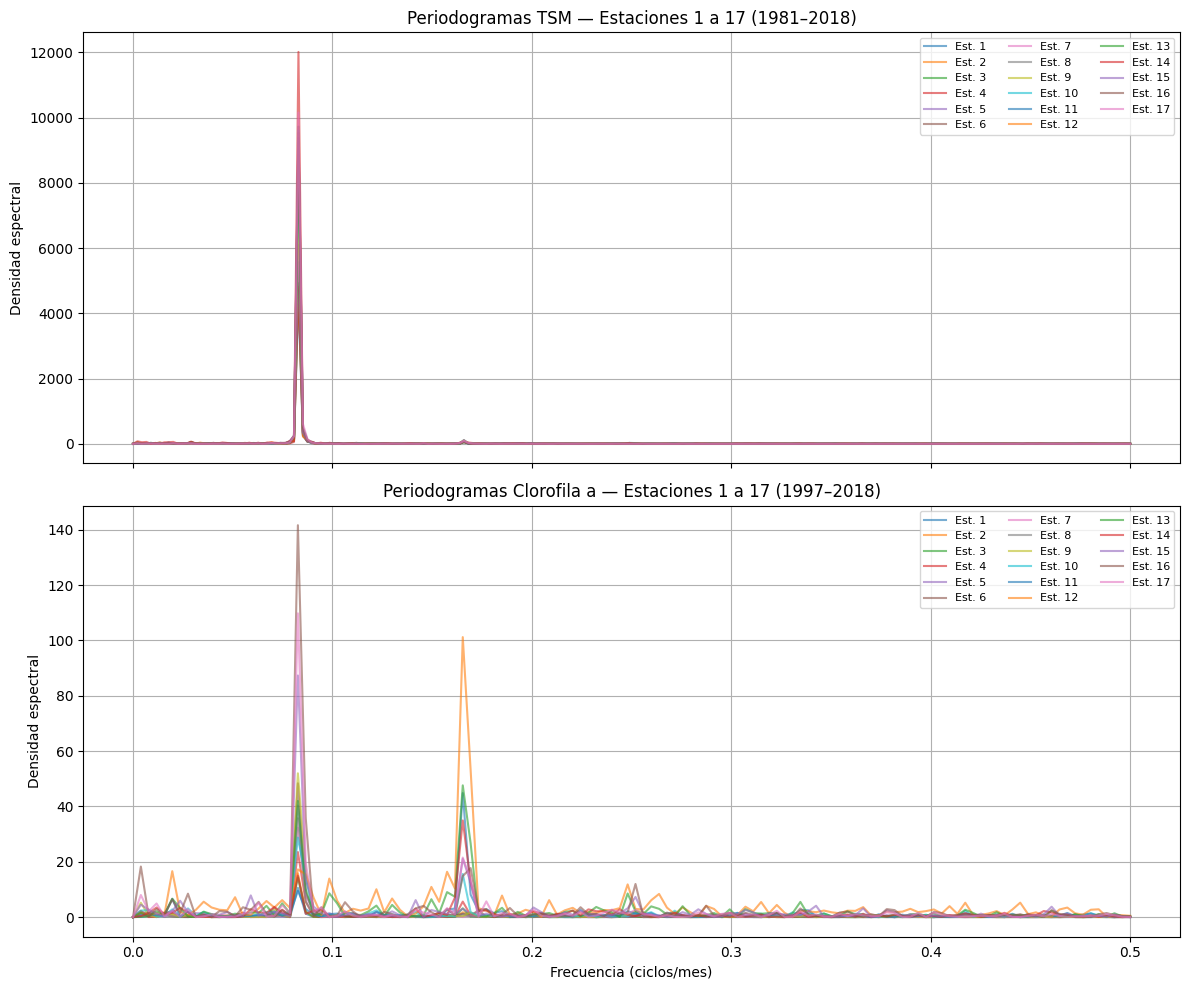

In [38]:
# Crear figuras
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Graficar periodogramas de TSM
for i, df in enumerate(df_tsm):
    f_tsm, Pxx_tsm = periodogram(df['tsm'], fs=1, detrend='linear')
    ax1.plot(f_tsm, Pxx_tsm, alpha=0.6, label=f'Est. {i+1}')

ax1.set_title('Periodogramas TSM — Estaciones 1 a 17 (1981–2018)')
ax1.set_ylabel('Densidad espectral')
ax1.grid(True)
ax1.legend(ncol=3, fontsize=8)

# Graficar periodogramas de CHLA
for i, df in enumerate(df_chla):
    f_chla, Pxx_chla = periodogram(df['chla'], fs=1, detrend='linear')
    ax2.plot(f_chla, Pxx_chla, alpha=0.6, label=f'Est. {i+1}')

ax2.set_title('Periodogramas Clorofila a — Estaciones 1 a 17 (1997–2018)')
ax2.set_xlabel('Frecuencia (ciclos/mes)')
ax2.set_ylabel('Densidad espectral')
ax2.grid(True)
ax2.legend(ncol=3, fontsize=8)

plt.tight_layout()
plt.show()

In [39]:
# Guardar resultados
top_tsm = []
top_chla = []

# Recorremos cada estación
for i in range(17):
    # TSM
    f_tsm, Pxx_tsm = periodogram(df_tsm[i]['tsm'], fs=1, detrend='linear')
    top_idxs_tsm = np.argsort(Pxx_tsm)[-5:][::-1]  # top 5 potencias descendentes
    top_freqs_tsm = f_tsm[top_idxs_tsm]
    top_powers_tsm = Pxx_tsm[top_idxs_tsm]
    top_tsm.append(list(zip(top_freqs_tsm, top_powers_tsm)))

    # CHLA
    f_chla, Pxx_chla = periodogram(df_chla[i]['chla'], fs=1, detrend='linear')
    top_idxs_chla = np.argsort(Pxx_chla)[-5:][::-1]
    top_freqs_chla = f_chla[top_idxs_chla]
    top_powers_chla = Pxx_chla[top_idxs_chla]
    top_chla.append(list(zip(top_freqs_chla, top_powers_chla)))

In [40]:
# Comparación por estación
resumen = []

for i in range(17):
    for j in range(5):
        resumen.append({
            'estacion': f'est_{i+1}',
            'rank': j + 1,
            'freq_tsm': top_tsm[i][j][0],
            'power_tsm': top_tsm[i][j][1],
            'freq_chla': top_chla[i][j][0],
            'power_chla': top_chla[i][j][1],
        })

df_resumen = pd.DataFrame(resumen)


In [41]:
df_resumen

,estacion,rank,freq_tsm,power_tsm,freq_chla,power_chla
0,est_1,1,0.082960,4474.788905,0.082677,10.611591
1,est_1,2,0.085202,255.930544,0.165354,1.353657
2,est_1,3,0.080717,121.567478,0.086614,1.238070
3,est_1,4,0.165919,79.271464,0.015748,0.865572
4,est_1,5,0.087444,66.877609,0.169291,0.643415
...,...,...,...,...,...,...
80,est_17,1,0.082960,10155.254833,0.082677,109.809468
81,est_17,2,0.085202,612.862260,0.165354,21.535518
82,est_17,3,0.080717,230.945962,0.086614,19.725943
83,est_17,4,0.087444,148.476481,0.169291,13.687638


In [49]:
df_resumen[df_resumen["rank"] == 1][["estacion","freq_tsm"]]

,estacion,freq_tsm
0,est_1,0.08296
5,est_2,0.08296
10,est_3,0.08296
15,est_4,0.08296
20,est_5,0.08296
25,est_6,0.08296
30,est_7,0.08296
35,est_8,0.08296
40,est_9,0.08296
45,est_10,0.08296


## Frecuencia Dominante en TSM — Estaciones 1 a 17

Al analizar los periodogramas de la Temperatura Superficial del Mar (TSM) para las 17 estaciones del Golfo de California, se observó un patrón notable: **todas las estaciones comparten la misma frecuencia dominante**.

### Frecuencia dominante común

- **Frecuencia**: 0.08296 ciclos/mes  
- **Período equivalente**:  
  
  $\frac{1}{0.08296} \approx 12.05 \text{ meses} \approx 1 \text{ año}$

### Interpretación

- Esta frecuencia indica un **ciclo anual perfectamente definido** en todas las estaciones.
- El hecho de que sea exactamente la misma en las 17 ubicaciones sugiere una **respuesta homogénea al ciclo estacional**, probablemente impulsada por factores climáticos como la radiación solar, temperatura atmosférica y dinámica oceánica.
- La consistencia de esta frecuencia refuerza la idea de que la TSM en el Golfo de California está fuertemente condicionada por la **estacionalidad climática**.

### Conclusión

Este resultado estadístico demuestra que, independientemente de la ubicación geográfica dentro del golfo, la TSM sigue un patrón **predominantemente anual**, lo cual es fundamental para la modelación de procesos físicos, biológicos y climáticos en la región.


In [50]:
df_resumen[df_resumen["rank"] == 2][["estacion","freq_tsm"]]

,estacion,freq_tsm
1,est_1,0.085202
6,est_2,0.085202
11,est_3,0.085202
16,est_4,0.085202
21,est_5,0.085202
26,est_6,0.085202
31,est_7,0.085202
36,est_8,0.085202
41,est_9,0.085202
46,est_10,0.085202


## Segunda Frecuencia Dominante en TSM — Estaciones 1 a 17

Además de la frecuencia dominante anual (≈ 0.0830 ciclos/mes), el análisis espectral revela que **todas las estaciones comparten una segunda frecuencia significativa común**:

### Frecuencia secundaria común

- **Frecuencia**: 0.085202 ciclos/mes  
- **Período equivalente**:  
  $\frac{1}{0.085202} \approx 11.74 \text{ meses}$

### Interpretación

- Esta frecuencia está muy cerca del valor anual, pero con una **ligera variación** respecto a la frecuencia principal (≈ 0.0830).
- Su presencia en todas las estaciones sugiere que el ciclo anual **no es perfectamente armónico**, sino que puede estar **modulado o distorsionado** por efectos locales como:
  - variaciones interanuales,
  - fases del ENSO,
  - o procesos oceanográficos regionales.

- También es posible que esta frecuencia represente un **armónico secundario del ciclo anual**, capturado debido a pequeñas fluctuaciones o no linealidades en la serie temporal.

### Conclusión

La existencia de una **segunda frecuencia cercana al ciclo anual** en todas las estaciones refuerza la idea de que la TSM está influida principalmente por patrones estacionales, aunque no de forma perfectamente sinusoidal. Este hallazgo apunta hacia una **estructura periódica compleja**, pero coherente a lo largo de toda la región del Golfo de California.


In [51]:
df_resumen[df_resumen["rank"] == 3][["estacion","freq_tsm"]]

,estacion,freq_tsm
2,est_1,0.080717
7,est_2,0.080717
12,est_3,0.080717
17,est_4,0.087444
22,est_5,0.080717
27,est_6,0.087444
32,est_7,0.080717
37,est_8,0.080717
42,est_9,0.080717
47,est_10,0.080717


## Tercera Frecuencia Dominante en TSM — Estaciones 1 a 17

A partir del análisis espectral de TSM, la tercera frecuencia dominante muestra **mayor variabilidad** entre estaciones, a diferencia de las dos primeras que eran completamente consistentes.

### Distribución de la tercera frecuencia

| Frecuencia (ciclos/mes) | Estaciones donde aparece | Período aproximado |
|--------------------------|---------------------------|---------------------|
| 0.080717                 | est_1, est_2, est_3, est_5, est_7, est_8, est_9, est_10, est_11, est_13, est_15, est_16, est_17 | ≈ 12.39 meses |
| 0.087444                 | est_4, est_6, est_12       | ≈ 11.44 meses |
| 0.078475                 | est_14                     | ≈ 12.74 meses |

### Interpretación

- Aunque las frecuencias siguen siendo cercanas al **ciclo anual**, ya no son idénticas en todas las estaciones.
- Esto indica que existen **pequeñas diferencias en la estructura de la señal anual**, posiblemente causadas por:
  - efectos geográficos locales (latitud, profundidad),
  - condiciones atmosféricas particulares,
  - o características propias de la dinámica marina en ciertas estaciones.
- En todos los casos, el período asociado sigue rondando los **12 meses**, por lo que el carácter estacional continúa siendo dominante, pero con **matices específicos por ubicación**.

### Conclusión

El análisis de la tercera frecuencia dominante en TSM revela una **transición hacia una mayor heterogeneidad espacial**. Esto puede ser importante para modelos más detallados que busquen capturar **variaciones locales** en la respuesta térmica del océano en el Golfo de California.


In [52]:
df_resumen[df_resumen["rank"] == 4][["estacion","freq_tsm"]]

,estacion,freq_tsm
3,est_1,0.165919
8,est_2,0.087444
13,est_3,0.165919
18,est_4,0.165919
23,est_5,0.165919
28,est_6,0.080717
33,est_7,0.165919
38,est_8,0.165919
43,est_9,0.087444
48,est_10,0.087444


## Cuarta Frecuencia Dominante en TSM — Estaciones 1 a 17

A medida que descendemos en el orden de importancia de las frecuencias (rank 4), se observa una mayor diversidad entre estaciones, aunque siguen apareciendo algunos patrones recurrentes.

### Distribución de la cuarta frecuencia

| Frecuencia (ciclos/mes) | Estaciones donde aparece          | Período aproximado |
|--------------------------|-----------------------------------|---------------------|
| 0.165919                 | est_1, est_3, est_4, est_5, est_7, est_8 | ≈ 6.03 meses |
| 0.087444                 | est_2, est_9, est_10, est_11, est_13, est_15, est_16, est_17 | ≈ 11.44 meses |
| 0.080717                 | est_6, est_12, est_14             | ≈ 12.39 meses |

### Interpretación

- La frecuencia **0.165919 ciclos/mes** aparece en 6 estaciones y corresponde aproximadamente a **un ciclo semestral**, lo cual podría reflejar:
  - fenómenos intraanuales como **variaciones de productividad biológica**,
  - **alternancia de masas de agua**,
  - o efectos climáticos regionales con una periodicidad de 6 meses.
  
- La frecuencia **0.087444 ciclos/mes**, aunque cercana al ciclo anual, persiste como una señal secundaria en varias estaciones, indicando posibles **modulaciones del ciclo anual**.

- La frecuencia **0.080717 ciclos/mes**, también cercana al año, aparece en otras estaciones como una alternativa dominante secundaria.

### Conclusión

La cuarta frecuencia dominante revela patrones **más variables y localizados**, pero sigue mostrando coherencia con escalas temporales anuales y semestrales. El ciclo semestral comienza a emerger con más claridad en algunas estaciones, lo que podría ser relevante para estudios de productividad primaria, surgencias, o influencia de vientos estacionales en el Golfo de California.


In [53]:
df_resumen[df_resumen["rank"] == 5][["estacion","freq_tsm"]]

,estacion,freq_tsm
4,est_1,0.087444
9,est_2,0.165919
14,est_3,0.087444
19,est_4,0.080717
24,est_5,0.087444
29,est_6,0.089686
34,est_7,0.087444
39,est_8,0.078475
44,est_9,0.165919
49,est_10,0.165919


## Quinta Frecuencia Dominante en TSM — Estaciones 1 a 17

En el análisis de la quinta frecuencia más significativa de la Temperatura Superficial del Mar (TSM), observamos una mayor dispersión en los valores de frecuencia. Sin embargo, algunas frecuencias se repiten en varias estaciones, manteniéndose patrones semestrales y anuales relevantes.

### Distribución de la quinta frecuencia

| Frecuencia (ciclos/mes) | Estaciones donde aparece          | Período aproximado |
|--------------------------|-----------------------------------|---------------------|
| 0.087444                 | est_1, est_3, est_5, est_7, est_14 | ≈ 11.44 meses |
| 0.165919                 | est_2, est_9, est_10, est_11, est_12, est_15, est_17 | ≈ 6.03 meses |
| 0.080717                 | est_4                             | ≈ 12.39 meses |
| 0.089686                 | est_6                             | ≈ 11.15 meses |
| 0.078475                 | est_8, est_16                     | ≈ 12.75 meses |
| 0.029148                 | est_13                            | ≈ 34.29 meses (~2.9 años) |

### Interpretación

- La frecuencia **0.165919 ciclos/mes** (semestre) es nuevamente la más común, lo que refuerza su importancia como **componente cíclico secundario** en muchas estaciones.
- La frecuencia **0.087444 ciclos/mes**, que ya había aparecido antes, vuelve a manifestarse como **armónico cercano al ciclo anual**, presente en 5 estaciones.
- Aparecen nuevas frecuencias como **0.029148 ciclos/mes** (≈2.9 años) en la estación 13, lo que puede indicar la presencia de **ciclos multianuales** poco frecuentes pero potencialmente significativos, posiblemente ligados a fenómenos como ENSO.
- La diversidad creciente de frecuencias sugiere que las **señales menos potentes** (rango bajo del periodograma) pueden capturar patrones más complejos o ruido local.

### Conclusión

El análisis de la quinta frecuencia dominante evidencia un balance entre **ciclos estacionales persistentes** (anuales y semestrales) y la aparición de **ciclos específicos por estación**, algunos de ellos de mayor escala temporal. Esto refuerza la necesidad de enfoques localizados o multiescalares en la modelación de la TSM en el Golfo de California.


In [54]:
df_resumen[df_resumen["rank"] == 1][["estacion","freq_chla"]]

,estacion,freq_chla
0,est_1,0.082677
5,est_2,0.082677
10,est_3,0.082677
15,est_4,0.082677
20,est_5,0.082677
25,est_6,0.082677
30,est_7,0.082677
35,est_8,0.082677
40,est_9,0.082677
45,est_10,0.082677


## Frecuencia Dominante en Clorofila — Estaciones 1 a 17

El análisis espectral mediante periodograma para la serie de **Clorofila a** revela dos frecuencias dominantes distintas entre las estaciones, lo que indica la presencia de **dos patrones cíclicos predominantes** según la ubicación geográfica.

### Distribución de la frecuencia dominante (rank 1)

| Frecuencia (ciclos/mes) | Estaciones donde aparece                       | Período aproximado |
|--------------------------|------------------------------------------------|---------------------|
| 0.082677                 | est_1, est_2, est_3, est_4, est_5, est_6, est_7, est_8, est_9, est_10, est_15, est_16, est_17 | ≈ 12.09 meses |
| 0.165354                 | est_11, est_12, est_13, est_14                 | ≈ 6.05 meses |

### Interpretación

- La frecuencia **0.082677 ciclos/mes** es la dominante en 13 de las 17 estaciones, indicando un ciclo de aproximadamente **12 meses**, característico de una **estacionalidad anual** fuerte.
- La frecuencia **0.165354 ciclos/mes**, dominante en 4 estaciones, corresponde a un ciclo de **6 meses**, lo cual sugiere un patrón **semestral** en esas regiones específicas.
- Esta división sugiere que, a diferencia de la TSM (donde todas las estaciones compartían un ciclo anual dominante), la **clorofila presenta una mayor variabilidad espacial en su comportamiento periódico**.

### Conclusión

El ciclo **anual** sigue siendo el más común en la dinámica de la clorofila en el Golfo de California, pero la presencia de estaciones donde domina un ciclo **semestral** indica posibles diferencias en **dinámica biológica o en la disponibilidad de nutrientes**. Esto podría deberse a condiciones locales como surgencias, mezclas verticales o influencias de vientos estacionales en ciertas zonas del golfo.


In [55]:
df_resumen[df_resumen["rank"] == 2][["estacion","freq_chla"]]

,estacion,freq_chla
1,est_1,0.165354
6,est_2,0.086614
11,est_3,0.165354
16,est_4,0.165354
21,est_5,0.086614
26,est_6,0.086614
31,est_7,0.086614
36,est_8,0.086614
41,est_9,0.086614
46,est_10,0.165354


## Segunda Frecuencia Dominante en Clorofila — Estaciones 1 a 17

La segunda frecuencia más importante del espectro de Clorofila a muestra un **mayor grado de variabilidad** entre estaciones respecto a la frecuencia dominante, aunque ciertos valores se repiten en múltiples ubicaciones.

### Distribución de la segunda frecuencia (rank 2)

| Frecuencia (ciclos/mes) | Estaciones donde aparece                                 | Período aproximado |
|--------------------------|----------------------------------------------------------|---------------------|
| 0.165354                 | est_1, est_3, est_4, est_10, est_15, est_17              | ≈ 6.05 meses |
| 0.086614                 | est_2, est_5, est_6, est_7, est_8, est_9, est_16         | ≈ 11.55 meses |
| 0.082677                 | est_11, est_13, est_14                                   | ≈ 12.09 meses |
| 0.169291                 | est_12                                                   | ≈ 5.91 meses |

### Interpretación

- La frecuencia **0.165354 ciclos/mes** (≈ 6 meses) continúa siendo relevante en varias estaciones, mostrando persistencia de un patrón semestral.
- Las frecuencias **0.086614** y **0.082677** son cercanas al ciclo anual, lo que indica una **modulación secundaria del ciclo estacional**.
- La aparición de **0.169291** en est_12 podría deberse a una variante local del patrón semestral o una mezcla de señales.

### Conclusión

Mientras que la frecuencia dominante en Clorofila se agrupaba principalmente en dos valores (anual o semestral), la segunda frecuencia muestra un **conjunto más rico de variaciones**, lo cual sugiere que:
- Las estaciones pueden estar influenciadas por **múltiples procesos periódicos superpuestos**, 
- y que existe **heterogeneidad espacial** en la forma en que la estacionalidad impacta la biomasa fitoplanctónica.

Este tipo de análisis es útil para detectar diferencias entre regiones del golfo y puede orientar investigaciones sobre procesos ecológicos específicos que afectan la productividad primaria.


In [56]:
df_resumen[df_resumen["rank"] == 3][["estacion","freq_chla"]]

,estacion,freq_chla
2,est_1,0.086614
7,est_2,0.165354
12,est_3,0.086614
17,est_4,0.086614
22,est_5,0.165354
27,est_6,0.070866
32,est_7,0.251969
37,est_8,0.003937
42,est_9,0.003937
47,est_10,0.086614


## Tercera Frecuencia Dominante en Clorofila — Estaciones 1 a 17

La tercera frecuencia más relevante en el espectro de Clorofila muestra una **amplia diversidad** entre estaciones, incluyendo tanto componentes estacionales como señales de muy baja frecuencia.

### Distribución de la tercera frecuencia (rank 3)

| Frecuencia (ciclos/mes) | Estaciones donde aparece                     | Período aproximado |
|--------------------------|----------------------------------------------|---------------------|
| 0.086614                 | est_1, est_3, est_4, est_10, est_15, est_17  | ≈ 11.55 meses |
| 0.165354                 | est_2, est_5                                 | ≈ 6.05 meses |
| 0.070866                 | est_6                                        | ≈ 14.11 meses |
| 0.251969                 | est_7                                        | ≈ 3.97 meses |
| 0.003937                 | est_8, est_9, est_16                         | ≈ 254 meses (~21 años) |
| 0.169291                 | est_11, est_13, est_14                       | ≈ 5.91 meses |
| 0.082677                 | est_12                                       | ≈ 12.09 meses |

### Interpretación

- Las frecuencias **0.086614 y 0.082677** cercanas al ciclo anual siguen presentes en múltiples estaciones, manteniendo la **influencia de la estacionalidad**.
- La frecuencia **0.165354** (≈6 meses) también persiste como componente cíclico clave.
- La aparición de **frecuencias muy bajas** como **0.003937 ciclos/mes** (~21 años de periodo) sugiere la presencia de **tendencias de largo plazo o componentes ruidosos** mal diferenciados, que podrían corresponder a efectos de aliasing o cambios de régimen.
- La frecuencia **0.251969** (≈4 meses) en est_7 podría reflejar fenómenos cíclicos **intraestacionales**, como eventos recurrentes de productividad o perturbaciones locales.

### Conclusión

El análisis de la tercera frecuencia dominante en Clorofila evidencia una señal más compleja y heterogénea en comparación con TSM:
- Aunque las señales anuales y semestrales se mantienen, aparecen **componentes de frecuencia baja y alta** que sugieren fenómenos más transitorios o de más largo plazo.
- Esto resalta la **mayor variabilidad en los procesos biológicos** que regulan la clorofila, en contraste con los más estables procesos físicos que dominan la temperatura del mar.

Este nivel de análisis es crucial para comprender la diversidad de factores que afectan la dinámica del fitoplancton en distintas zonas del Golfo de California.


In [57]:
df_resumen[df_resumen["rank"] == 4][["estacion","freq_chla"]]

,estacion,freq_chla
3,est_1,0.015748
8,est_2,0.169291
13,est_3,0.015748
18,est_4,0.074803
23,est_5,0.019685
28,est_6,0.173228
33,est_7,0.003937
38,est_8,0.251969
43,est_9,0.070866
48,est_10,0.027559


## Cuarta Frecuencia Dominante en Clorofila — Estaciones 1 a 17

La cuarta frecuencia más significativa en la serie temporal de Clorofila a muestra una **dispersión considerable** entre estaciones. Esta variabilidad refleja la influencia de múltiples escalas temporales en la dinámica del fitoplancton.

### Distribución de la cuarta frecuencia (rank 4)

| Frecuencia (ciclos/mes) | Estaciones donde aparece                 | Período aproximado       |
|--------------------------|------------------------------------------|---------------------------|
| 0.169291                 | est_2, est_15, est_16, est_17            | ≈ 5.91 meses              |
| 0.015748                 | est_1, est_3                              | ≈ 63.5 meses (~5.3 años)  |
| 0.019685                 | est_5, est_11, est_12                    | ≈ 50.8 meses (~4.2 años)  |
| 0.074803                 | est_4                                    | ≈ 13.4 meses              |
| 0.173228                 | est_6                                    | ≈ 5.77 meses              |
| 0.003937                 | est_7                                    | ≈ 254 meses (~21 años)    |
| 0.251969                 | est_8                                    | ≈ 3.97 meses              |
| 0.070866                 | est_9                                    | ≈ 14.1 meses              |
| 0.027559                 | est_10                                   | ≈ 36.3 meses (~3 años)    |
| 0.086614                 | est_13                                   | ≈ 11.55 meses             |
| 0.161417                 | est_14                                   | ≈ 6.2 meses               |

### Interpretación

- Las frecuencias **0.169291** y **0.173228** (≈6 meses) siguen destacando como un patrón recurrente en varias estaciones, apuntando a un **ciclo semestral persistente**.
- Aparecen varias **frecuencias de muy baja magnitud** como **0.015748**, **0.019685**, **0.003937**, y **0.027559**, las cuales representan **ciclos multianuales**:
  - Estas pueden estar relacionadas con **tendencias a largo plazo**, cambios de régimen climático, o incluso **ruido estructural**.
- Por otro lado, algunas estaciones presentan **ciclos cortos** como **0.251969** (≈4 meses), indicando posibles **fluctuaciones rápidas** en la concentración de clorofila.

### Conclusión

El rango de frecuencias observado en la cuarta posición evidencia que la variabilidad de la clorofila es influenciada por procesos de **corto, mediano y largo plazo**. A diferencia de la TSM, donde los patrones eran altamente consistentes entre estaciones, la clorofila presenta una señal **más fragmentada y diversa**. Esto refuerza la naturaleza más dinámica y localmente modulada de los procesos biológicos frente a los procesos físicos.

Este nivel de detalle es útil para estudios que buscan **identificar drivers locales** de productividad biológica en el Golfo de California.


In [58]:
df_resumen[df_resumen["rank"] == 5][["estacion","freq_chla"]]

,estacion,freq_chla
4,est_1,0.169291
9,est_2,0.015748
14,est_3,0.074803
19,est_4,0.003937
24,est_5,0.090551
29,est_6,0.090551
34,est_7,0.090551
39,est_8,0.303150
44,est_9,0.251969
49,est_10,0.019685


## Quinta Frecuencia Dominante en Clorofila — Estaciones 1 a 17

La quinta frecuencia dominante en las series temporales de Clorofila a revela la mayor dispersión de valores, lo cual sugiere que, más allá de los patrones estacionales, existen **múltiples escalas temporales activas**, muchas de ellas específicas por estación.

### Distribución de la quinta frecuencia (rank 5)

| Frecuencia (ciclos/mes) | Estaciones donde aparece                 | Período aproximado       |
|--------------------------|------------------------------------------|---------------------------|
| 0.169291                 | est_1                                    | ≈ 5.91 meses              |
| 0.015748                 | est_2                                    | ≈ 63.5 meses (~5.3 años)  |
| 0.074803                 | est_3                                    | ≈ 13.4 meses              |
| 0.003937                 | est_4, est_17                             | ≈ 254 meses (~21 años)    |
| 0.090551                 | est_5, est_6, est_7                       | ≈ 11.05 meses             |
| 0.303150                 | est_8                                    | ≈ 3.3 meses               |
| 0.251969                 | est_9                                    | ≈ 4.0 meses               |
| 0.019685                 | est_10                                   | ≈ 50.8 meses (~4.2 años)  |
| 0.161417                 | est_11                                   | ≈ 6.2 meses               |
| 0.157480                 | est_12, est_13                            | ≈ 6.35 meses              |
| 0.070866                 | est_14                                   | ≈ 14.1 meses              |
| 0.059055                 | est_15                                   | ≈ 16.9 meses              |
| 0.165354                 | est_16                                   | ≈ 6.05 meses              |

### Interpretación

- Las frecuencias **0.157–0.169 ciclos/mes** (≈6 meses) siguen presentes como un patrón intermedio común, incluso en el rango de menor potencia relativa.
- Se detectan **frecuencias de muy baja magnitud** (0.003937, 0.015748, 0.019685), que pueden indicar:
  - **Tendencias de largo plazo**,
  - Ruido estructurado,
  - O bien fenómenos multianuales como El Niño–La Niña (ENSO).
- Las frecuencias **0.251969 y 0.303150** sugieren la existencia de **variabilidad intraestacional** en ciertas estaciones (≈3–4 meses), tal vez relacionada con eventos de surgencia o pulsos productivos breves.
- Algunas frecuencias como **0.090551** (~11 meses) y **0.074803** (~13.4 meses) se acercan al ciclo anual, pero ligeramente desplazadas, indicando posible **modulación o asincronía** respecto a la estacionalidad estricta.

### Conclusión

Esta última capa del análisis espectral muestra una **señal sumamente rica y compleja** en la serie de Clorofila a. A diferencia de la TSM, donde las cinco principales frecuencias fueron altamente consistentes y estacionales, en la clorofila encontramos un **mosaico de patrones** que van desde lo subestacional hasta lo multianual, reforzando su sensibilidad a procesos locales, climáticos y biogeoquímicos.

Estos resultados resaltan la necesidad de un enfoque multiescalar y espacialmente explícito para modelar la productividad biológica en el Golfo de California.
